In [29]:
image_resolution = 128
depth = 5
init_features = 32
debug_print_model = False

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def debug_print(text):
    if debug_print_model:
        print(text)


class SimpleUnetAgnostic(nn.Module):
    def __init__(self, depth=8, init_features=64):
        super(SimpleUnetAgnostic, self).__init__()
        self.depth = depth
        
        self.down_convs = nn.ModuleList()
        self.down_convs_pools = nn.ModuleList()

        last_layer_features = 3
        for i in range(1, depth):
            layer_multiplier = 2**(i-1)
            down_conv = nn.Sequential(
                nn.Conv2d(last_layer_features, init_features * layer_multiplier, kernel_size=3, padding=1),
                nn.BatchNorm2d(init_features * layer_multiplier),
                nn.ReLU(inplace=True)
            )

            last_layer_features = init_features * layer_multiplier
            self.down_convs.append(down_conv)
            self.down_convs_pools.append(nn.MaxPool2d(2, 2))
            debug_print(f"Down conv {i} expected input size: [N, {last_layer_features}, H, W]")

        self.up_convs = nn.ModuleList()

        for i in range(depth - 1, 0, -1):
            layer_multiplier = 2**(i-1)
            in_channels = init_features * layer_multiplier * 2
            out_channels = init_features * layer_multiplier

            if i < depth - 1:
                in_channels += init_features * layer_multiplier

            up_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            
            self.up_convs.append(up_conv)
            debug_print(f"Up conv {depth - i} expected input size: [N, {in_channels}, H, W]")

        self.final_layer = nn.Conv2d(init_features, 1, kernel_size=3, padding=1)
        debug_print(f"Final conv expected input size: [N, {init_features}, H, W]")

    def forward(self, x):
        down_convs_processed = []

        _x = x
        for i, down_conv in enumerate(self.down_convs):
            _x = down_conv(_x)
            debug_print(f"Down conv {i} output size: {_x.size()}")
            down_convs_processed.append(_x)
            _x = self.down_convs_pools[i](_x)
            debug_print(f"After pooling {i} output size: {_x.size()}")
        
        i = len(down_convs_processed) - 1
        for j, up_conv in enumerate(self.up_convs):
            _x = F.interpolate(_x, scale_factor=2, mode='bilinear', align_corners=False)
            debug_print(f"After interpolate {j} output size: {_x.size()}")
            debug_print(f"Trying concat {i} inputs: {_x.size()}, {down_convs_processed[i].size()}")
            _x = torch.cat([_x, down_convs_processed[i]], dim=1)
            debug_print(f"After concat {j} output size: {_x.size()}")
            _x = up_conv(_x)
            debug_print(f"Up conv {j} output size: {_x.size()}")
            i -= 1

        _x = self.final_layer(_x)
        
        x_out = torch.sigmoid(_x)
        debug_print(f"Final output size: {x_out.size()}")
        return x_out

In [31]:
import os
import torch

cwd = os.getcwd()

device = torch.device('cpu')

model = SimpleUnetAgnostic(depth=depth, init_features=init_features)


state_dictionary = torch.load(f'{cwd}/backups/epoch99.pth')

model.load_state_dict(state_dictionary)
model.eval()

model.to(device)

SimpleUnetAgnostic(
  (down_convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down_convs_pools): ModuleList(
    (0-3):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7992519..1.8279185].


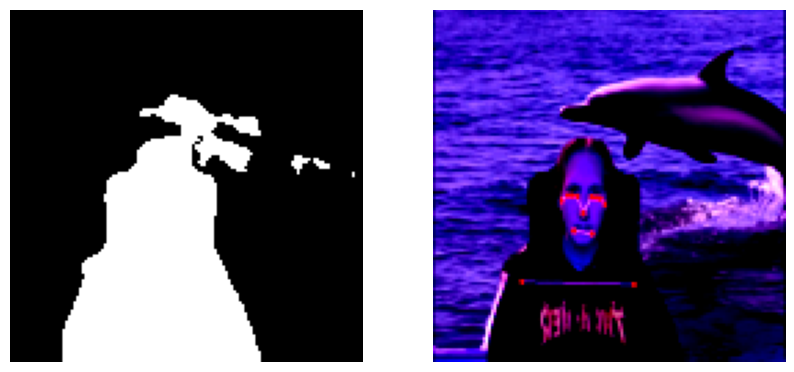

In [32]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch

def plot(mask, image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    mask_np = mask.squeeze().cpu().detach().numpy()
    image_np = image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    
    axs[0].imshow(mask_np, cmap='gray')
    axs[0].axis('off')

    axs[1].imshow(image_np)
    axs[1].axis('off')

    plt.show()

image_transform = transforms.Compose([
    transforms.Resize((image_resolution, image_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.4117, 0.5926, 0.3815]), [0.3299, 0.3250, 0.3212]) # Values calculated in model.ypynb
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image_tensor = image_transform(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor.to(device)
    return image_tensor

image = load_image(f'{cwd}/test.png')

output = model(image) > 0.5

plot(output, image)

